## Project 5, Vehicle Detection

In [1]:
###Importing all the nescessary libraries

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.feature import hog
import glob
import time
import cv2
import os
import random
import gc
# from sklearn.utils import shuffle
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import Adam

%matplotlib inline

In [2]:
###Producing hog images and hog features
def hog_features_and_image(image,
                           orient,
                           pixel_per_cell,
                           cell_per_block,
                           vis,
                           feature_vector=True):
    
    hog_features,hog_image=hog(image, orientations=orient,
                          pixels_per_cell=(pixel_per_cell,pixel_per_cell),
                          block_norm= 'L2-Hys',
                          cells_per_block=(cell_per_block,cell_per_block),
                          visualise=True,
                          feature_vector=True)
    if vis==True:                           ###returns image if you want to visualize
        return hog_features,hog_image
    elif vis==False:
        return hog_features
    
    
###Peforming spatial binning and histogram
def spatial_binning(image,size=(32,32)):                         ###For removing the unnecessary details
    features=cv2.resize(image,size).ravel()                      ###Resizing and then laying out in a linear array
    return features                                     ###can also be done by extracting each color space and then performing      
                                                        ###operation and then stacking each layer back to obtain the image
###personally I cannot see the difference between them (the two images), the second method just looks more technical and cool


def get_histogram_features(image,nbins):
    ###Since all images in RGB channel
    ###creating histogram features for each channel
    R_hist=np.histogram(image[:,:,0],bins=nbins,range=(0,256))
    G_hist=np.histogram(image[:,:,1],bins=nbins,range=(0,256))
    B_hist=np.histogram(image[:,:,2],bins=nbins,range=(0,256))
    
    bin_edges=R_hist[1]                                          ###Position two[1] in the array contains the position
    bin_centres=(bin_edges[1:]+bin_edges[0:len(bin_edges)-1]/2)  ###of the histogram feature
    
    ###concatenate and return
    histogram_features=np.concatenate((R_hist[0],G_hist[0],B_hist[0])) ###Position one[0] in the array hold the value 
                                                                    ###which tell us the amount of data present for a particular
                                                                    ###value of R G or B or the concerned color space
    return R_hist,G_hist,B_hist,bin_edges,bin_centres,histogram_features

def Feature_extraction(images,color_space='RGB',
                       hog_channel=0,
                       orient=12,pixels_per_cell=4,cells_per_block=2,
                       spatial_size=(32,32),
                       hist_bins=32,
                       hog_features=True,
                       hist_features=True,
                       spatial_features=True
                      ):

    features=[] ###array for appending the feature vector
    for image in images:
        file_features=[]
        
        image=mpimg.imread(image)
        
        ###converting to the appropriate channel required
        if (color_space!='RGB'):
            if (color_space=='HLS'):
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif (color_space=='HSV'):
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif (color_space=='YUV'):
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif (color_space=='LAB'):                      ###Didn't knew there are this many color spaces (o.0)
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
            elif (color_space=='LUV'):
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif (color_space=='YCrCb'):
                Image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        else:
            Image=np.copy(image)
        ###Getting the spatial features    
        if spatial_features==True:
            Spatial_features=spatial_binning(Image,size=spatial_size)
            file_features.append(Spatial_features)
        
        ### Getting the histogram features
        if hist_features==True:
            rh,gh,bh,Edges,Centres,histogram_features=get_histogram_features(Image,nbins=hist_bins)
            file_features.append(histogram_features)
        
        ### Getting the HOG features
        if hog_features==True:
            if hog_channel=='ALL':
                Hog_features = []
                for channel in range(Image.shape[2]):
                    Hog_features.append(hog_features_and_image(Image[:,:,channel], 
                                        orient, pixels_per_cell, cells_per_block, 
                                        vis=False, feature_vector=True))
                Hog_features = np.ravel(Hog_features)        
            else:
                Hog_features = hog_features_and_image(Image[:,:,hog_channel], orient, 
                            pixels_per_cell, cells_per_block, vis=False, feature_vector=True)
            file_features.append(Hog_features)
        
        ###concatenate to make one feature file for all the features as every feature function return an array of features
        ###rather than individual elements
        features.append(np.concatenate(file_features))
        
    return (features)


### Let us print a few examples for image output from both car and not car folders

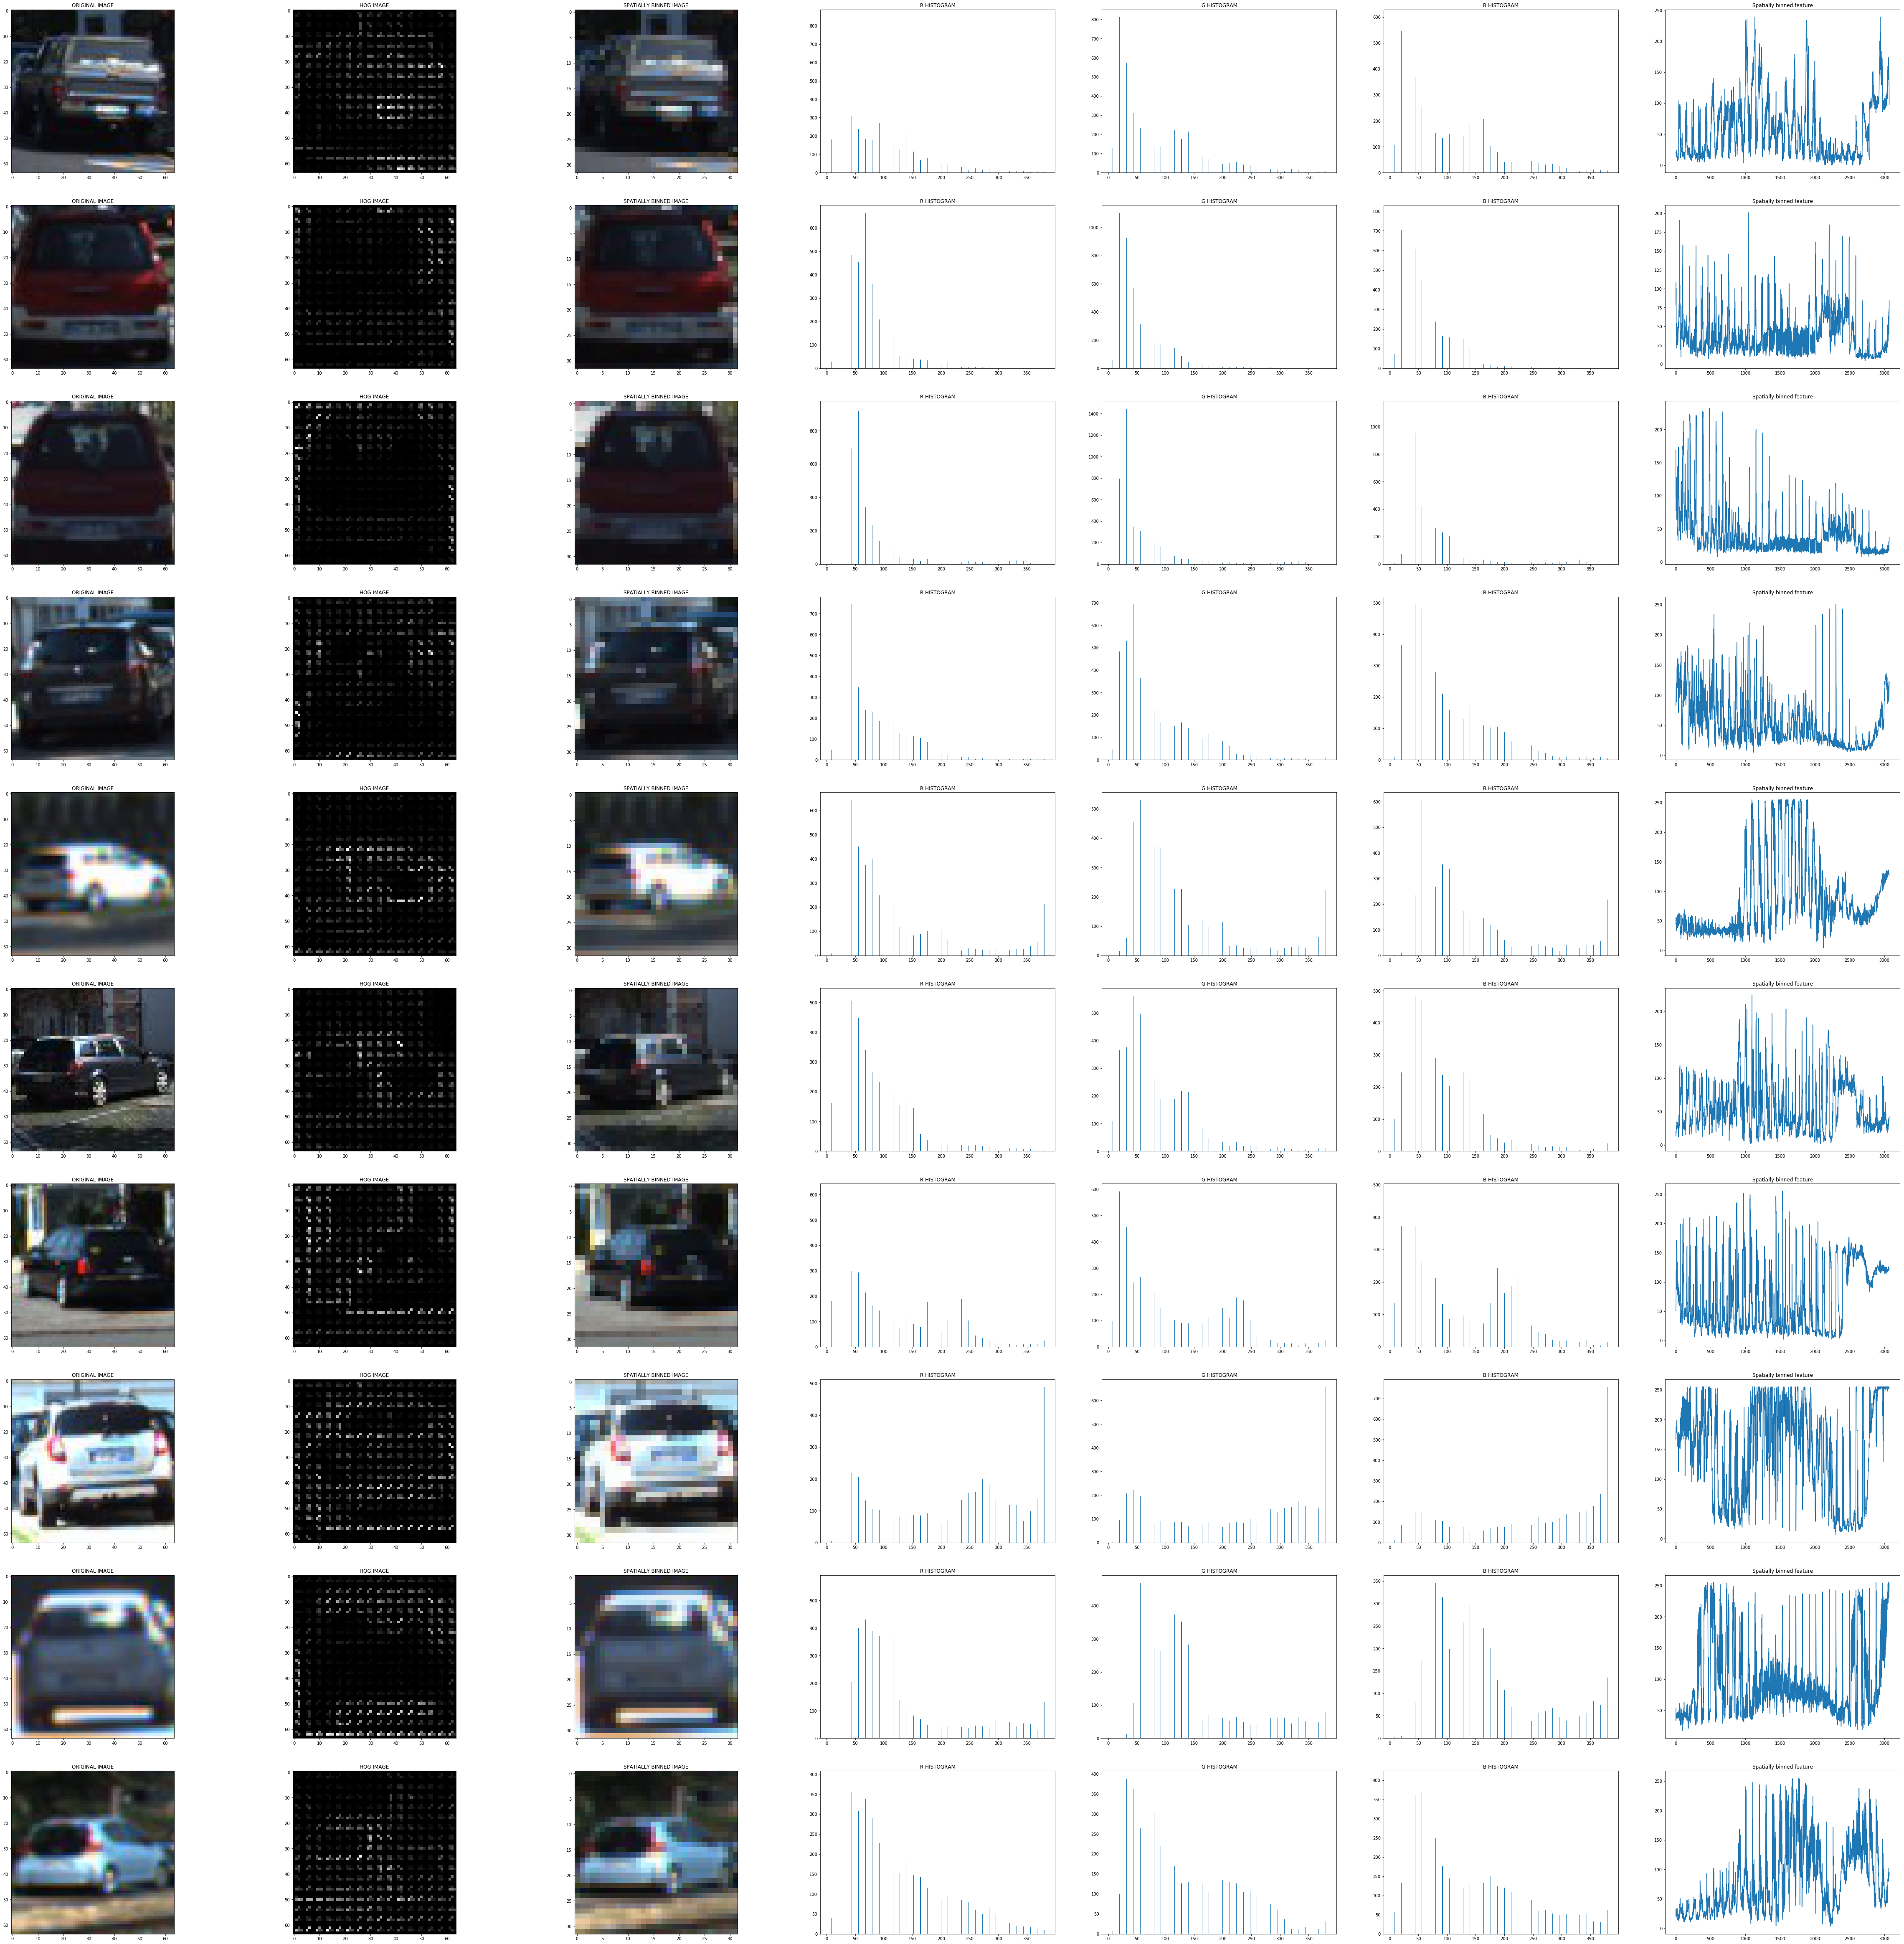

In [3]:
imageCARS=glob.glob('C:/Users/SIDAUS/CarND-Vehicle-Detection-master/EXAMPLES_CARS/**.jpeg')

###To print the example output from spatial binning, hog image and histogram of image
fig=plt.figure(figsize=(64,64))
i=0

for cars in imageCARS:
    carImage=mpimg.imread(cars)
    
    HOG_FEATURES,HOG_IMAGE=hog_features_and_image(carImage[:,:,0],orient=12,
                                     pixel_per_cell=4,cell_per_block=2,
                                     vis=True,
                                     feature_vector=True)
    
    ###We need the HOG features so we keep the visulization on
    
    RH,GH,BH,EDGES,CENTRES,HIST_FEATURES=get_histogram_features(carImage,nbins=32)
    
    SPATIAL_FEATURES=spatial_binning(carImage,size=(32,32))
    
    SPATIAL_IMAGE=cv2.resize(carImage,(32,32))
    
    if RH is not None:            ###This will always be true because we will always be using a three channeled color space 
        plt.subplot(10,7,i+1)
        plt.title('ORIGINAL IMAGE')  ### through out the whole project
        plt.imshow(carImage)
        plt.subplot(10,7,i+2)
        plt.title('HOG IMAGE')
        plt.imshow(HOG_IMAGE,cmap='gray')
        plt.subplot(10,7,i+3)
        plt.title('SPATIALLY BINNED IMAGE')
        plt.imshow(SPATIAL_IMAGE,cmap='gray')
        plt.subplot(10,7,i+4)
        plt.title('R HISTOGRAM')
        plt.bar(CENTRES,RH[0])
        plt.subplot(10,7,i+5)
        plt.title('G HISTOGRAM')
        plt.bar(CENTRES,GH[0])
        plt.subplot(10,7,i+6)
        plt.title('B HISTOGRAM')
        plt.bar(CENTRES,BH[0])
        plt.subplot(10,7,i+7)
        plt.title('Spatially binned feature')
        plt.plot(SPATIAL_FEATURES)
    i+=7 
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

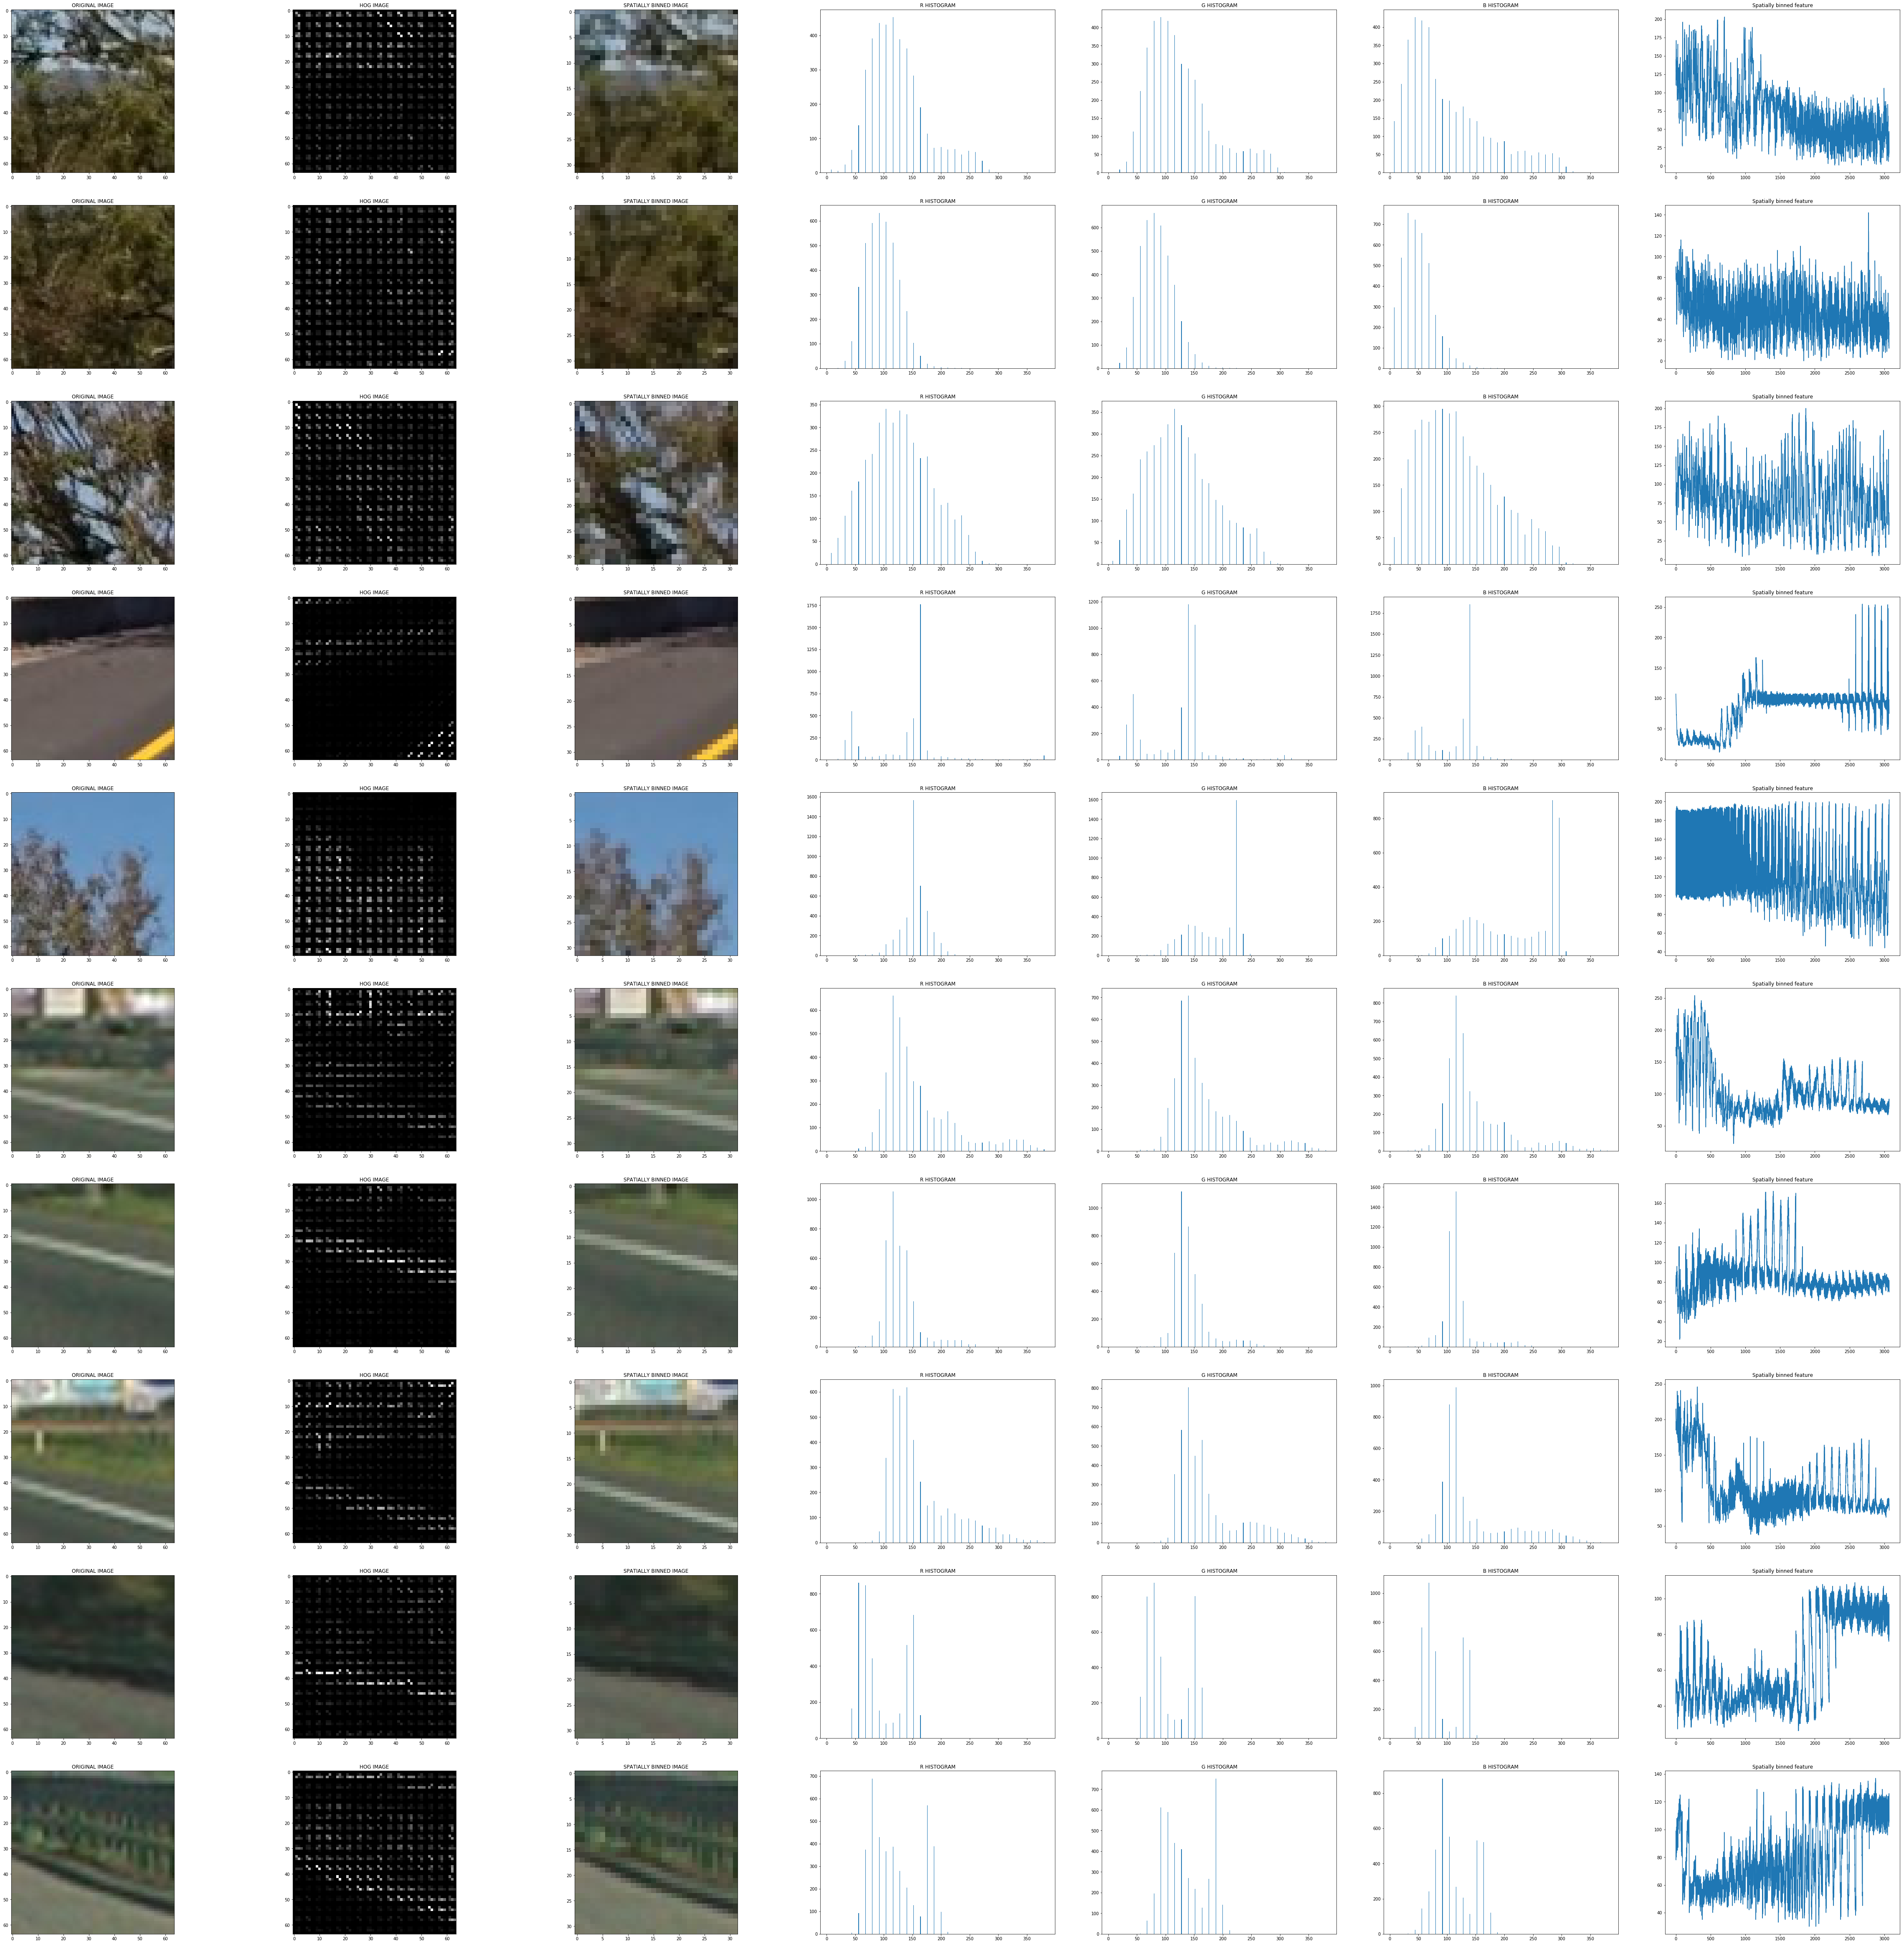

In [4]:
imageNOT_CARS=glob.glob('C:/Users/SIDAUS/CarND-Vehicle-Detection-master/EXAMPLES_NOT_CARS/**.jpeg')

fig=plt.figure(figsize=(64,64))
i=0
for not_cars in imageNOT_CARS:
    not_carImage=mpimg.imread(not_cars)
    
    HOG_FEATURES,HOG_IMAGE=hog_features_and_image(not_carImage[:,:,0],orient=12,
                                     pixel_per_cell=4,cell_per_block=3,
                                     vis=True,
                                     feature_vector=True)
    
    ###We need the HOG features so we keep the visulization on
    
    RH,GH,BH,EDGES,CENTRES,HIST_FEATURES=get_histogram_features(not_carImage,nbins=32)
    
    SPATIAL_FEATURES=spatial_binning(not_carImage,size=(32,32))
    
    SPATIAL_IMAGE=cv2.resize(not_carImage,(32,32))
    
    if RH is not None:            ###This will always be true because we will always be using a three channeled color space 
        plt.subplot(10,7,i+1)
        plt.title('ORIGINAL IMAGE')  ### through out the whole project
        plt.imshow(not_carImage)
        plt.subplot(10,7,i+2)
        plt.title('HOG IMAGE')
        plt.imshow(HOG_IMAGE,cmap='gray')
        plt.subplot(10,7,i+3)
        plt.title('SPATIALLY BINNED IMAGE')
        plt.imshow(SPATIAL_IMAGE)
        plt.subplot(10,7,i+4)
        plt.title('R HISTOGRAM')
        plt.bar(CENTRES,RH[0])
        plt.subplot(10,7,i+5)
        plt.title('G HISTOGRAM')
        plt.bar(CENTRES,GH[0])
        plt.subplot(10,7,i+6)
        plt.title('B HISTOGRAM')
        plt.bar(CENTRES,BH[0])
        plt.subplot(10,7,i+7)
        plt.title('Spatially binned feature')
        plt.plot(SPATIAL_FEATURES)
    i+=7
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

In [5]:
### Initializing the variables that we will be using
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
visualize=False # to get not images as outputs
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


### NOW FOR THE TRAINING USING A SUPPORT VECTOR MACHINE

In [6]:
### I tried some other settings as well for orientation, pixels per cell and cell per block, these pretty much get all the 
### necessary details for both car and non-car images.
gc.collect()
CARS=[]
NOT_CARS=[]
REQ_CARS=[]
REQ_NON_CARS=[]

###Lets make an array for the cars 
CAR_IMAGE=glob.glob('C:/Users/SIDAUS/CarND-Vehicle-Detection-master/CARS/*/*/*')
NON_CAR_IMAGE=glob.glob('C:/Users/SIDAUS/CarND-Vehicle-Detection-master/NON_CARS/*/*/*')

for images in CAR_IMAGE: ###making an array for car images
    CARS.append(images)        

###Similarly lets make an array for the non cars    
  
for images in NON_CAR_IMAGE: ###making an array for non car images
    NOT_CARS.append(images) 
            
###lets shuffle the data
CARS1=shuffle(CARS)
NOT_CARS1=shuffle(NOT_CARS)

# REQ_CARS=shuffle(CARS)
# REQ_NON_CARS=shuffle(NOT_CARS)

sample_size=random.randint(500,1000)

REQ_CARS=CARS1[:sample_size]
REQ_NON_CARS=NOT_CARS1[:sample_size]
    
### I am unable to use the generators and I donot have enough memory to train with so much data
### So I will not be using all the images

CAR_FEATURES=Feature_extraction(REQ_CARS, color_space=color_space,
                               hog_channel=hog_channel,
                               orient=orient,pixels_per_cell=pix_per_cell,cells_per_block=cell_per_block,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins,
                               hog_features=hog_feat,
                               hist_features=hist_feat,
                               spatial_features=spatial_feat 
                               )

NON_CAR_FEATURES=Feature_extraction(REQ_NON_CARS, color_space=color_space,
                                   hog_channel=hog_channel,
                                   orient=orient,pixels_per_cell=pix_per_cell,cells_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   hog_features=hog_feat,
                                   hist_features=hist_feat,
                                   spatial_features=spatial_feat 
                                   )


print ('Number of car images',len(CARS1))
print ('Number of non car images',len(NOT_CARS1))

Number of car images 9988
Number of non car images 10093


In [7]:
print ('Number of car images in the network',len(REQ_CARS))
print ('Number of non car images in the network',len(REQ_NON_CARS))
print (len(CAR_FEATURES))

Number of car images in the network 963
Number of non car images in the network 963
963


In [8]:
#stack for image feature vectors
X=np.vstack((CAR_FEATURES, NON_CAR_FEATURES)).astype(np.float64)
print (X.shape)

Y=np.hstack((np.ones(len(CAR_FEATURES)),np.zeros(len(NON_CAR_FEATURES))))
### LABELS FOR CAR IMAGES IS '1' WHEREAS FOR NON-CAR IMAGES IS '0'

### Train and validation split
rand=random.randint(0,100)
X_TRAIN,X_TEST,Y_TRAIN,Y_TEST=train_test_split(X,Y,test_size=0.25,random_state=rand)

X_scaler = StandardScaler().fit(X_TRAIN)
# Apply the scaler to X
X_TRAIN = X_scaler.transform(X_TRAIN)
X_TEST = X_scaler.transform(X_TEST)

#x_train=(X/127.5)-1 ### Feature normalization

###defining a support vector machine

svc=LinearSVC()
t=time.time()
svc.fit(X_TRAIN,Y_TRAIN)
t1=time.time()

print ('It took {} seconds to train the support vector machine.'.format(round((t1-t),2)))
print ('The accuracy of the machine was=',svc.score(X_TEST,Y_TEST))

(1926, 13968)
It took 55.56 seconds to train the support vector machine.
The accuracy of the machine was= 0.809128630705


In [9]:
print(X_scaler)
print(X.shape)
print(len(CAR_FEATURES))

StandardScaler(copy=True, with_mean=True, with_std=True)
(1926, 13968)
963


### Now to apply the sliding window, make heat maps and detect the cars (if we can)

In [10]:
def single_img_Feature_extraction(images,color_space='RGB',
                       hog_channel=0,
                       orient=12,pixels_per_cell=4,cells_per_block=2,
                       spatial_size=(32,32),
                       hist_bins=32,
                       hog_features=True,
                       hist_features=True,
                       spatial_features=True
                      ):
    
    #features=[] ###array for appending the feature vector
    #for image in images:
    file_features=[]
        
        #image=mpimg.imread(image_address)
        
        ###converting to the appropriate channel required
    if (color_space!='RGB'):
        if (color_space=='HLS'):
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        elif (color_space=='HSV'):
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        elif (color_space=='YUV'):
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
        elif (color_space=='LAB'):                      ###Didn't knew there are this many color spaces (o.0)
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
        elif (color_space=='LUV'):
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
        elif (color_space=='YCrCb'):
            Image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    else:
        Image=np.copy(image)
        ###Getting the spatial features    
    if spatial_features==True:
        Spatial_features=spatial_binning(Image,size=spatial_size)
        file_features.append(Spatial_features)
        
        ### Getting the histogram features
    if hist_features==True:
        rh,gh,bh,Edges,Centres,histogram_features=get_histogram_features(Image,nbins=hist_bins)
        file_features.append(histogram_features)
        
    ### Getting the HOG features
    if hog_features==True:
        if hog_channel=='ALL':
            Hog_features = []
            for channel in range(Image.shape[2]):
                Hog_features.append(hog_features_and_image(Image[:,:,channel], 
                                        orient, pixels_per_cell, cells_per_block, 
                                        vis=False, feature_vector=True))
            Hog_features = np.ravel(Hog_features)        
        else:
            Hog_features = hog_features_and_image(Image[:,:,hog_channel], orient, 
                            pixels_per_cell, cells_per_block, vis=False, feature_vector=True)
        file_features.append(Hog_features)
        
        ###concatenate to make one feature file for all the features as every feature function return an array of features
        ###rather than individual elements
    #features.append(np.concatenate(file_features))
        
    return np.concatenate(file_features)

In [11]:
def search_windows(img, windows, clf, scaler,
                  color_space='RGB',
                       hog_channel=0,
                       orient=12,pixels_per_cell=4,cells_per_block=2,
                       spatial_size=(32,32),
                       hist_bins=32,
                       hog_features=True,
                       hist_features=True,
                       spatial_features=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_Feature_extraction(test_img, color_space=color_space,
                                   hog_channel=hog_channel,
                                   orient=orient,pixels_per_cell=pix_per_cell,cells_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   hog_features=hog_feat,
                                   hist_features=hist_feat,
                                   spatial_features=spatial_feat 
                                   )
        
        print (len(features))
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [13]:
image = mpimg.imread('C:/Users/SIDAUS/CarND-Vehicle-Detection-master/test_images/test1.jpg')
draw_image = np.copy(image)
print (image.shape)

(720, 1280, 3)


In [14]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None,None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
print (len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


819
2744016


ValueError: operands could not be broadcast together with shapes (1,2744016) (13968,) (1,2744016) 